# Demonstration of Self-Organizing Maps (SOMs)
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/som_christmanFieldData.ipynb)


In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print("IN_COLAB = " + str(IN_COLAB))

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter

if(IN_COLAB):
    !pip install MiniSom
from minisom import MiniSom

import numpy.linalg as LA
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [ ]:
# set figure defaults
fig_text_default = 12.0
fig_title_default = fig_text_default * 1.1
plt.rc("font", size=fig_text_default, weight="normal", family="sans-serif")
plt.rc("axes", titlesize=fig_title_default, titleweight="bold")
mpl.rcParams["figure.dpi"] = 125

# plt.rc('lines', linewidth=linewidth_default)
# plt.rc('text', usetex=False)
# mpl.rcParams['xtick.labelsize'] = fig_text_default

sns.set()
sns.set_style("whitegrid")

In [ ]:
# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

# Get your data together

In [ ]:
filename = "http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2018-04-15&span=365&interval=hourly&units=m&fmt=csv"
data_0 = pd.read_csv(filename, header=0)
print(np.shape(data_0))

filename = "http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2019-04-15&span=365&interval=hourly&units=m&fmt=csv"
data_1 = pd.read_csv(filename, header=0)
print(np.shape(data_1))

filename = "http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2020-04-15&span=365&interval=hourly&units=m&fmt=csv"
data_2 = pd.read_csv(filename, header=0)
print(np.shape(data_2))

df = pd.concat([data_0, data_1, data_2])

# drop the units row (first row)
df = df.drop(index=0)
# sort values by date
df = df.sort_values(by=["DateTime"])
print(np.shape(df))
df

# print(data[0])
# print(data.shape[0]/(24.))

In [ ]:
grab_indices = [1, 2, 4, 8, 9, 10]
data = df.values[:, grab_indices].astype("float")

names_input = [
    "dateTime",
    "temp (C)",
    "RH (%)",
    "DewPt (C)",
    "Wind (m/s)",
    "Dir (deg.N)",
    "Gust (m/s)",
    "Gust Dir (deg.N)",
    "Pres (hPa)",
    "Solar (W/m^2)",
    "Precip (mm)",
]
names = [names_input[i] for i in grab_indices]

print(names)
print(data.shape)

In [ ]:
# standardize the data
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

## Train the SOM, visualize a sample

In [ ]:
# ----- MODIFY --------
dim = (8, 8)  # make initial SOM shape
som = MiniSom(
    dim[0],
    dim[1],
    np.shape(data)[1],  # initialize the SOM code
    sigma=1.0,
    learning_rate=0.01,
    neighborhood_function="gaussian",
)
## use the options below if you want something more like K-means
# dim = (2,2)
# som = MiniSom(dim[0],dim[1],np.shape(data)[1], sigma=.2, learning_rate = .1, neighborhood_function='gaussian')
# ----------------------

# initialize with PC weights when your SOM shape is 2D
if np.min(dim) > 1:
    som.pca_weights_init(data)

# train the SOMs
som.train_random(data, 50000, verbose=True)  # train over a random subset of the data

print("\n")
codebook = (
    som.get_weights()
)  # explore the "codebook", i.e. the different cluster centroids
print("codebook.shape = " + str(np.shape(codebook)))

dataCodebook = som.quantization(data)  # get the winning cluster centroid of each sample
print("dataCodebook.shape = " + str(np.shape(dataCodebook)))

dataNeurons = [
    som.winner(data[i, :]) for i in np.arange(0, data.shape[0])
]  # get the winning cluster (x,y) coordinate in the som grid (i.e. cluster number)
print("dataNeurons.shape = " + str(np.shape(dataNeurons)))

In [ ]:
# plot one particular sample (option for which sample is above)

# ----- MODIFY --------
sample = 710  # example sample to explore in detail
# ----------------------

neuron_sample = dataNeurons[sample]  # get the winning cluster number for this sample

plt.figure(figsize=(12 * 0.75, 6 * 0.75))
plt.plot(data[sample, :], "--", color="tab:gray", label="sample", linewidth=2.5)
plt.plot(dataCodebook[sample], color="tab:purple", label="SOM")
plt.xticks(np.arange(len(names)), names, fontsize=8)
plt.title(
    "Standarized Data Sample #"
    + str(sample)
    + "\nWinning Cluster = "
    + str(neuron_sample)
)
plt.axhline(color="gray", linewidth=0.5)
plt.ylim(-4, 4)
plt.ylabel("sigma")
plt.legend()
plt.show()

### Plot the SOM "patterns"
In this case, my SOM patterns aren't actually patterns, but values for each of my six variables. There are many ways I could plot this, but I have chosen to divide each of the variables into a grid, where each gridbox is associated with a different SOM. That is, the true "SOM #1" is actually a combination of all six variables taking on their values in the upper-left hand corner of the plot.

In [ ]:
my_cmap = plt.cm.get_cmap("RdBu_r")

# make the plot
plt.figure(figsize=(17 * 0.8, 10 * 0.8))
for ind in range(0, np.size(codebook, axis=2)):
    weights = codebook[:, :, ind]
    #     weights = np.abs(weights)
    #     weights[np.isnan(weights)==True] = 0.
    #     weights[weights<=0.] = 1.e-10
    ax = plt.subplot(2, 3, ind + 1)

    if np.min(weights.shape[1] == 1):
        weights = np.append(weights, weights, axis=1)
    elif np.min(weights.shape[0] == 1):
        weights = np.append(weights, weights, axis=0)

    plt.axis([0, weights.shape[1], 0, weights.shape[0]])
    #     if(names[ind] in 'Precip (mm)'):
    #         pl = plt.pcolormesh(weights, cmap = my_cmap, norm=colors.LogNorm(vmin=weights.min(), vmax=weights.max()))
    #         #pl = plt.pcolor(weights, cmap = my_cmap)
    #     else:
    pl = plt.pcolormesh(weights, cmap=my_cmap)

    plt.plot(neuron_sample[1] + 0.5, neuron_sample[0] + 0.5, "*r")
    plt.yticks([])
    plt.xticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)
    plt.title(names[ind])
    plt.clim(-2, 2)
plt.show()

### Plot the "hits" map
The "Hits Map" is a map of how many times a particular sample falls into a particular SOM. In our example here, what is the number of samples that look like each SOM? We see from the hits map below where the most frequent SOMs/states of the atmosphere lie. So, we can go and look at the figure above and see what values the different variables take-on during this time. Looks like "cold/moist/low wind/mix of pressures/cloudy/precipitating a little" (at least that is what it looked like when I ran this!).

In [ ]:
frequencies = np.zeros((dim[0], dim[1]))
x = np.zeros((dim[0], dim[1]))
y = np.zeros((dim[0], dim[1]))
for position, values in som.win_map(data).items():
    frequencies[position[0], position[1]] = len(values)
    x[position[0], position[1]] = position[0]
    y[position[0], position[1]] = position[1]

f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(
    np.flipud(frequencies), annot=True, fmt="g", linewidths=0.5, ax=ax, cbar=False
)
ax.axis("off")
plt.title("Frequencies")
plt.show()

## K-Means

In [ ]:
from scipy.cluster.vq import kmeans, vq

numclust = 20  # the number of clusters
n_iters = 20  # number of times to run the algorithm and take the best one

kclusters, kdist = kmeans(data, numclust, iter=n_iters)
kclasses, _ = vq(data, kclusters)

print("kclusters.shape = " + str(kclusters.shape))
print("kclasses.shape = " + str(kclasses.shape))

In [ ]:
sample_kclasses = kclasses[sample]
sample_kcluster = kclusters[sample_kclasses]
# ----------
plt.figure(figsize=(12 * 0.75, 6 * 0.75))
plt.plot(data[sample, :], "--", color="tab:gray", label="sample", linewidth=2.5)
plt.plot(sample_kcluster, color="tab:orange", label="kmeans")
plt.xticks(np.arange(len(names)), names, fontsize=8)
plt.title(
    "Standarized Data Sample #"
    + str(sample)
    + "\nWinning Cluster = "
    + str(sample_kclasses)
)
plt.axhline(color="gray", linewidth=0.5)
plt.ylim(-4, 4)
plt.ylabel("sigma")
plt.legend()
plt.show()

In [ ]:
## EOF Analysis

In [ ]:
Y = np.copy(data)
Ymean = np.nanmean(Y, axis=0)
X = Y - Ymean

# standardize the data - call it "Xw"
Xstd = np.nanstd(X, axis=0)
Xw = X / Xstd

C = 1.0 / np.size(Xw, axis=0) * np.dot(np.transpose(Xw), Xw)
print("shape of Cov Matrix = " + str(np.shape(C)))
print(C)

# calculate eigenvalues and eigenvectors of C; lam should be 7x1, E should be 7x7
lam, E = LA.eig(C)

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:, i]

pve = 100.0 * lam / np.sum(lam)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, np.size(pve) + 1.0), pve, "o-", linewidth=2, color="black")

plt.xlim(0.5, 6.5)
plt.xlabel("eigenvalue position")
plt.ylabel("percent variance explained (%)")

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X, axis=0)
eb = pve * np.sqrt(2.0 / Nstar)
plt.errorbar(
    np.arange(1, np.size(pve) + 1.0),
    pve,
    yerr=eb / 2,
    xerr=None,
    linewidth=1,
    color="black",
)

plt.show()

In [ ]:
# -----------MODIFY--------------------------
# which EOF do you want to plot?
eof_num = 1
# -------------------------------------------
# take only one eigenvector, user specified by "eof_num" above
e1 = E[:, eof_num - 1]  # e1 should be 7x1 or 1x7 depending on your software
# calculate the the PC associated with the EOF of interest
z1 = np.dot(Xw, e1)  # z1 should be 50x1 or 1x50 depending on your software
# standardize z1
z1 = (z1 - np.nanmean(z1)) / np.nanstd(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units,
# thus it uses the original "X" anomaly data
d1 = (1.0 / np.size(X, axis=0)) * np.dot(np.transpose(z1), X)

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data
d1s = (1.0 / np.size(Xw, axis=0)) * np.dot(np.transpose(z1), Xw)

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(d1s, "s-k", label="d1s", markersize=8)
plt.plot(e1, "s-r", label="e1", markersize=8)

plt.xticks(np.arange(len(names)), names, fontsize=8)
plt.xlim(-0.5, 5.5)

plt.legend()
plt.axhline(color="k", linewidth=0.5)
plt.ylabel("sigma")
plt.title("d (variables still in sigma units")

plt.show()

In [ ]:
print(
    "PC "
    + str(eof_num)
    + " value for sample #"
    + str(sample)
    + " = "
    + str(np.around(z1[sample], 3))
)

## Compare all of the methods together

Note that this is not a totally fair comparison, as the kmeans has a different number of clusters than SOMs, and EOFs are not actually clusters.

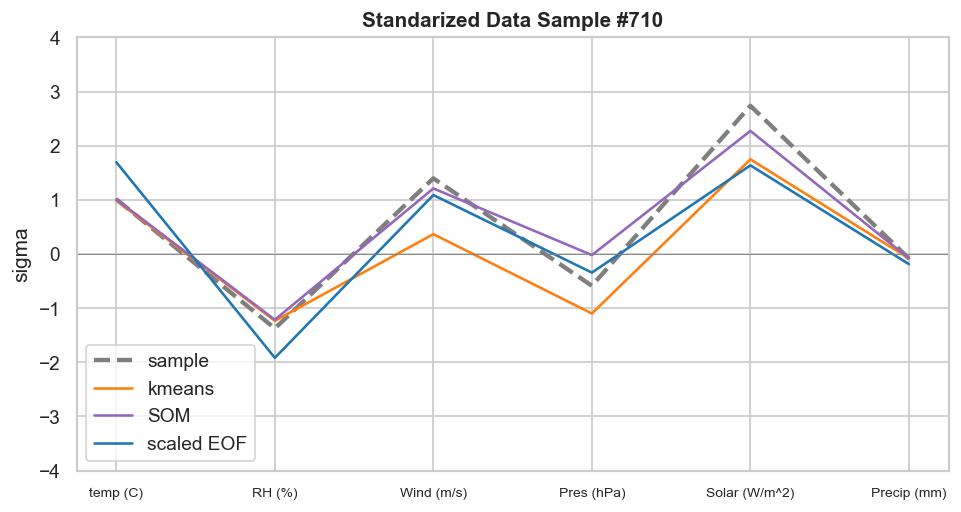

In [29]:
# ----------
plt.figure(figsize=(12 * 0.75, 6 * 0.75))
plt.plot(data[sample, :], "--", color="tab:gray", label="sample", linewidth=2.5)
plt.plot(sample_kcluster, color="tab:orange", label="kmeans")
plt.plot(dataCodebook[sample], color="tab:purple", label="SOM")
plt.plot(d1s * z1[sample], color="tab:blue", label="scaled EOF")
plt.xticks(np.arange(len(names)), names, fontsize=8)
plt.title("Standarized Data Sample #" + str(sample))
plt.axhline(color="gray", linewidth=0.5)
plt.ylim(-4, 4)
plt.ylabel("sigma")
plt.legend()
plt.show()

## Agglomerative Clustering / Heirarchical Clustering

https://en.wikipedia.org/wiki/Hierarchical_clustering

In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis that seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two categories:

Agglomerative: This is a "bottom-up" approach: Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

In [ ]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

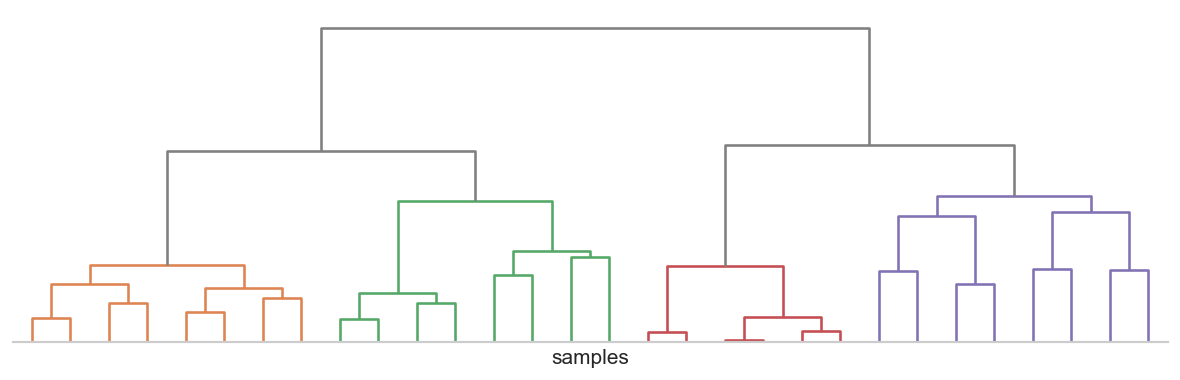

In [105]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

LEVELS = 4
model_full = []
model_full = AgglomerativeClustering(
    n_clusters=None,
    metric="euclidean",
    linkage="ward",
    distance_threshold=0.0,
    compute_full_tree=True,
).fit(data)

plt.figure(figsize=(12 * 0.8, 4 * 0.8))
plot_dendrogram(
    model_full,
    # truncate_mode=None,
    color_threshold=150,
    truncate_mode="level",
    p=LEVELS,
    get_leaves=True,
    distance_sort=False,
    above_threshold_color="gray",
    count_sort=True,
    leaf_rotation=-90,
    show_leaf_counts=False,
    labels=None,
)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.yticks([])
plt.xticks([])
plt.xlabel("samples")
plt.tight_layout()

In [98]:
model = []
model = AgglomerativeClustering(
    n_clusters=LEVELS, metric="euclidean", linkage="ward", distance_threshold=None
).fit(data)
n_clusters = len(np.unique(model.labels_))
classes = model.labels_
print(f"{classes.shape[0]} samples == {data.shape[0]} samples")

for c in range(n_clusters):
    i = np.where(classes == c)[0]
    print(f"Cluster {c} has {len(i)} samples")

26352 samples == 26352 samples
Cluster 0 has 14998 samples
Cluster 1 has 8853 samples
Cluster 2 has 7 samples
Cluster 3 has 2494 samples


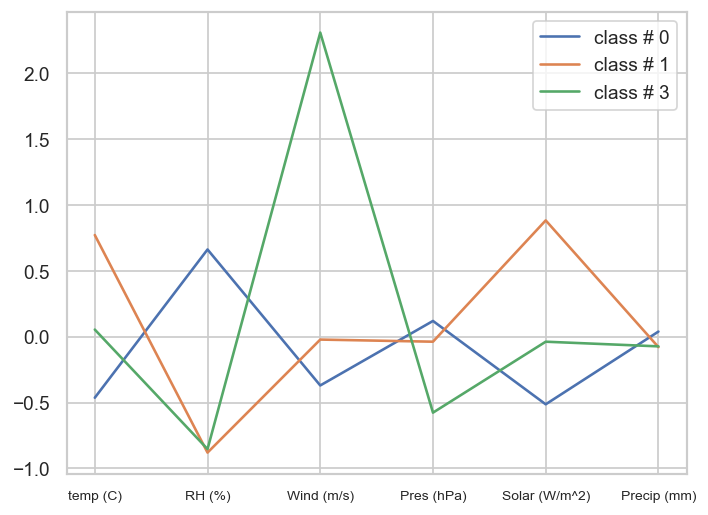

In [109]:
for c in range(n_clusters):
    # if c == 2:
    #     continue
    i = np.where(classes == c)[0]
    plt.plot(data[i,:].mean(axis=0), label=f"class # {c}")
plt.xticks(np.arange(len(names)), names, fontsize=8)
plt.legend()
plt.show()

# i = np.where(classes==2)[0]
# print(data[i,-1])